<h1>Code for Experiment 342</h1>

In [649]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator as RPI
from uncertainties import ufloat

<h2>Importing Images</h2>

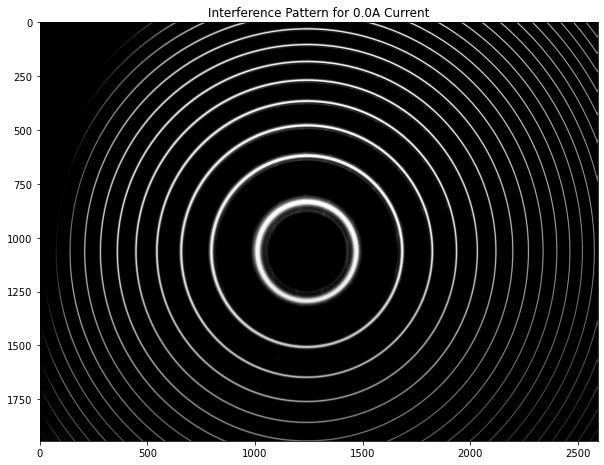

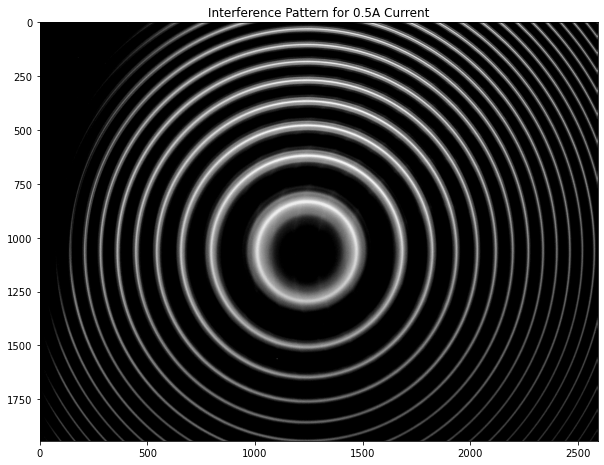

In [650]:
fileno = 2 # How many files were imported.
meas = 3 # Which measurement.

file = []
for i in range(fileno):
    file += [f"C:\\Users\\bayle\\OneDrive\\Documents\\University Documents\\2022 S1\\PHYSICS 390\\Experiment 342\\Data\\Measurement {meas}\\Hg_{i*4.5:.1f}_90.jpg"]

xArray = np.arange(2592) # Pixel Width
yArray = np.arange(1944) # Pixel Height

ImX,ImY = np.meshgrid(xArray,yArray,sparse = False, indexing = 'xy')

ImageCtr = (1237, 1059) # X,Y Pixels of the center

im = []
for i in range(fileno):
    F = plt.imread(file[i])
    imgray = 0.2125*F[:,:,0] + 0.7154*F[:,:,1] + 0.0721*F[:,:,2]
    im += [imgray/imgray.max()]

for i in range(fileno):
    plt.figure(figsize=(10,10))
    plt.imshow(im[i], origin = 'upper', cmap = 'gist_gray')
    plt.title(f'Interference Pattern for {i*0.5:.1f}A Current')
    plt.show()

## Interpolate and Plot

Based on the code supplied; a regular grid interpolator was used to construct an average radial intensity.

In [651]:
N = 20 # Number of Radial Cuts
M = 900 # Number of Data Points

arrays = []

Stepsize = 1 # Pixels 

for k in range(fileno):
    TestArrayTotal = np.zeros(M)
    TestArray = np.zeros(M)

    for i in range(N):

        angle = 2*np.pi/N*(i+1/2)

        UnitX = np.cos(angle)
        UnitY = np.sin(angle)
        
        PointsX  = PointsT*UnitX*Stepsize + ImageCtr[1]
        PointsY = PointsT*UnitY*Stepsize + ImageCtr[0]
        
        ImageInterp = RPI((yArray,xArray), im[k], fill_value = 0, bounds_error = False)
        
        for j in range(M):
            TestArray[j] = ImageInterp([PointsX[j],PointsY[j]])
        
        TestArrayTotal += TestArray/N

    Max = max(TestArrayTotal)
    TestArrayTotal = TestArrayTotal/Max
    arrays += [TestArrayTotal]

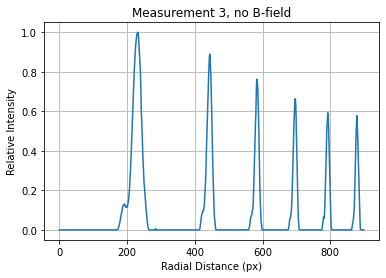

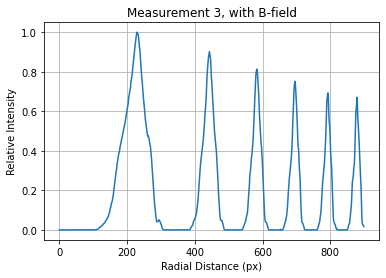

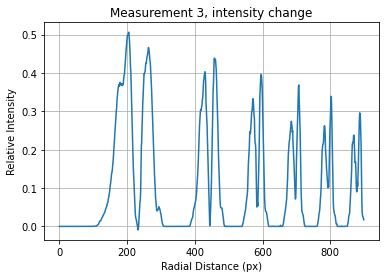

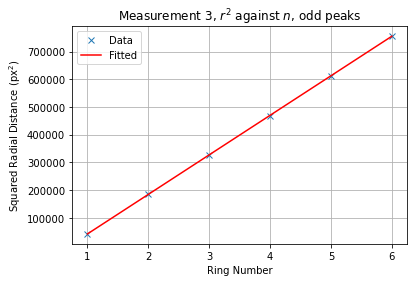

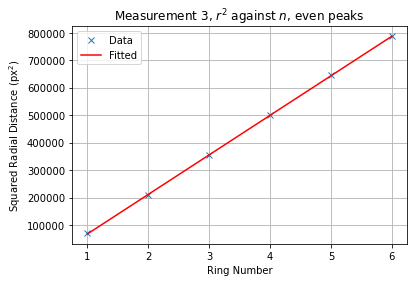

142678.6+/-2.2 143999.7+/-1.8


In [652]:
plt.figure()
plt.title(f'Measurement {meas}, no B-field')
plt.xlabel('Radial Distance (px)')
plt.ylabel('Relative Intensity')
plt.plot(arrays[0])
plt.grid()
plt.show()

plt.figure()
plt.title(f'Measurement {meas}, with B-field')
plt.xlabel('Radial Distance (px)')
plt.ylabel('Relative Intensity')
plt.plot(arrays[-1])
plt.grid()
plt.show()

plt.figure()
plt.title(f'Measurement {meas}, intensity change')
plt.xlabel('Radial Distance (px)')
plt.ylabel('Relative Intensity')
plt.plot(arrays[-1] - arrays[0])
plt.grid()
plt.show()

def maxima(arr, conf): # Identification of maxima according to a certain confidence limit.
    x = np.array([i for i in range(len(arr)) if arr[i] >= conf]) # Set of all points which have the requisite intensity.
    y = np.zeros(len(arr)) # Set of points where the range has started/ended.
    for i in range(len(arr)):
        if (i in x and not (i+1 in x)) or (not (i in x) and (i+1 in x)): # If it's either the first or the last over the confidence limit.
            y[i] = 1

    z = []
    for i in range(len(y)):
        if y[i] == 1:
            z += [i] # z is the isolated set of points for which a max has started/finished.
    
    maxlist=[] # Maxlist is the list of maxima.
    unclist=[] # Unclist is a list of uncertainties.

    for i in range(int(len(z)/2)):
        peak = max(arr[z[2*i]:z[2*i+1]]) # In between a start and an end.
        maxlist += [l for l in range(len(arr)) if arr[l]==peak] # Add a maximum.
        unclist += [(z[2*i+1] - z[2*i])/2] # Half width at the requisite intensity.

    return np.array(maxlist), np.array(unclist)


X, Y = maxima(arrays[-1]-arrays[0], 0.2) # X is the maxima, Y is the uncertainty.

# The following is partitioning X and Y into even and odd peaks. The naming convention is,
# unfortunately, contrary to the convention in titles and the report.
even = []
deven = []
odd = []
dodd = []

A = [i for i in range(len(X)) if np.mod(i,2)==0]
for i in range(len(A)):
    even += [X[A[i]]]
even = np.array(even)

A = [i for i in range(len(Y)) if np.mod(i,2)==0]
for i in range(len(A)):
    deven += [Y[A[i]]]
deven = np.array(deven)

A = [i for i in range(len(X)) if np.mod(i,2)==1]
for i in range(len(A)):
    odd += [X[A[i]]]
odd = np.array(odd)

A = [i for i in range(len(Y)) if np.mod(i,2)==1]
for i in range(len(A)):
    dodd += [Y[A[i]]]
dodd = np.array(dodd)

# List of peak numbers.
numbersplit = np.arange(len(X)/2)+1

# Fitting to find slope.
pe, cove = np.polyfit(numbersplit, even**2, 1, w=1/deven, cov='unscaled')
po, covo = np.polyfit(numbersplit, odd**2, 1, w=1/dodd, cov='unscaled')

plt.figure()
plt.title(f'Measurement {meas}, $r^2$ against $n$, odd peaks')
plt.xlabel('Ring Number')
plt.ylabel('Squared Radial Distance (px$^2$)')
plt.grid()
plt.plot(numbersplit, even**2, 'x', label='Data')
plt.plot(numbersplit, pe[0]*numbersplit + pe[1], color='red', label='Fitted')
plt.legend()
plt.show()

plt.figure()
plt.title(f'Measurement {meas}, $r^2$ against $n$, even peaks')
plt.xlabel('Ring Number')
plt.ylabel('Squared Radial Distance (px$^2$)')
plt.grid()
plt.plot(numbersplit, odd**2, 'x', label='Data')
plt.plot(numbersplit, po[0]*numbersplit + po[1], color='red', label='Fitted')
plt.legend()
plt.show()

# Slopes.
s1 = ufloat(pe[0], np.sqrt(cove[0,0]))
s2 = ufloat(po[0], np.sqrt(covo[0,0]))
print(s1, s2)

144007.2+/-1.7


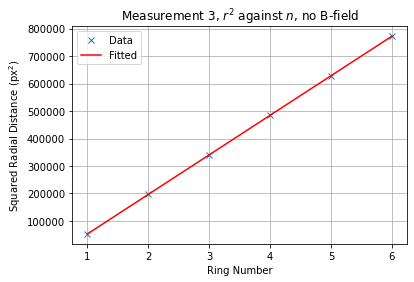

In [653]:
# Slope for no magnetic field.
W, Z = maxima(arrays[0], 0.4)
numbers = np.arange(len(W))+1
p0, cov0 = np.polyfit(numbers, W**2, 1, w=1/Z, cov='unscaled')
s0 = ufloat(p0[0], np.sqrt(cov0[0,0]))
int0 = ufloat(p0[1], np.sqrt(cov0[1,1]))
print(s0)

plt.figure()
plt.title(f'Measurement {meas}, $r^2$ against $n$, no B-field')
plt.xlabel('Ring Number')
plt.ylabel('Squared Radial Distance (px$^2$)')
plt.grid()
plt.plot(numbers, W**2, 'x', label='Data')
plt.plot(numbers, p0[0]*numbers + p0[1], color='red', label='Fitted')
plt.legend()
plt.show()

In [654]:
separation = np.mean(odd**2 - even**2)
sigma = np.std(odd**2 - even**2, ddof=1)
separation = ufloat(separation, sigma/np.sqrt(len(odd)))
factor = s0/separation
Bhalf = ufloat(0.54, 0.005)*3*factor
t = ufloat(1994714, 5)*1e-9
from scipy.constants import pi, h, c
hbar = h/(2*pi)
muB = h*c/(2*Bhalf*t)
print(muB)

(6.19+/-0.25)e-24


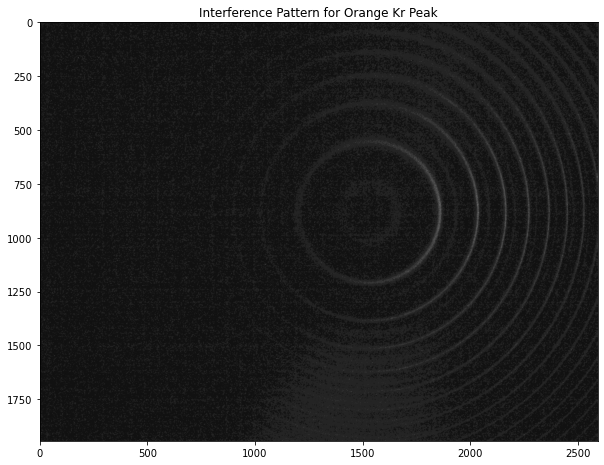

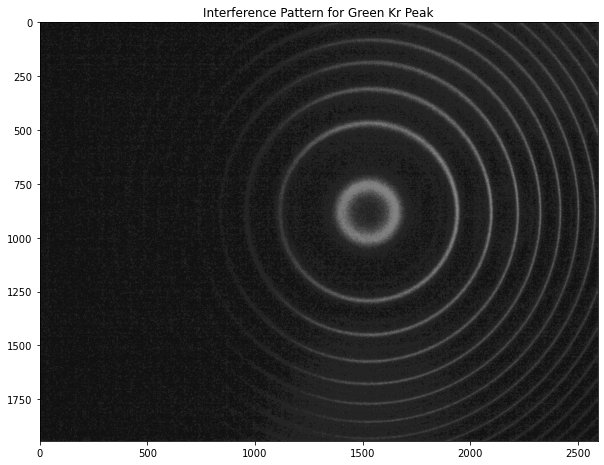

In [655]:
fileKr1 = "C:\\Users\\bayle\\OneDrive\\Documents\\University Documents\\2022 S1\\PHYSICS 390\\Experiment 342\\Data\\Kr_1.jpg"
fileKr2 = "C:\\Users\\bayle\\OneDrive\\Documents\\University Documents\\2022 S1\\PHYSICS 390\\Experiment 342\\Data\\Kr_2.jpg"

# Generally, the suffix '1' for a variable refers to the orange Kr,
# and the suffix '2' to the green Kr.

F1 = plt.imread(fileKr1)
imgray = 0.2125*F1[:,:,0] + 0.7154*F1[:,:,1] + 0.0721*F1[:,:,2]
Image1 = imgray/imgray.max()

F2 = plt.imread(fileKr2)
imgray = 0.2125*F2[:,:,0] + 0.7154*F2[:,:,1] + 0.0721*F2[:,:,2]
Image2 = imgray/imgray.max()

centre = (1523, 883)

plt.figure(figsize=(10,10))
plt.imshow(Image1, origin = 'upper', cmap = 'gist_gray')
plt.title(f'Interference Pattern for Orange Kr Peak')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(Image2, origin = 'upper', cmap = 'gist_gray')
plt.title(f'Interference Pattern for Green Kr Peak')
plt.show()

In [656]:
ImageInterp = RPI((yArray,xArray), Image1, fill_value = 0, bounds_error = False)

TestArrayTotal = np.zeros(M)
TestArray = np.zeros(M)
N = 50

for i in range(N):

    angle = 2*np.pi/N*(i+1/2)

    UnitX = np.cos(angle)
    UnitY = np.sin(angle)
    
    PointsX  = PointsT*UnitX*Stepsize + centre[1]
    PointsY = PointsT*UnitY*Stepsize + centre[0]
    
    ImageInterp = RPI((yArray,xArray), Image1, fill_value = 0, bounds_error = False)

    for j in range(M):
        TestArray[j] = ImageInterp([PointsX[j],PointsY[j]])

    TestArrayTotal += TestArray/N

Max = max(TestArrayTotal)
interp1 = TestArrayTotal/Max

ImageInterp = RPI((yArray,xArray), Image1, fill_value = 0, bounds_error = False)

TestArrayTotal = np.zeros(M)
TestArray = np.zeros(M)

for i in range(N):

    angle = 2*np.pi/N*(i+1/2)

    UnitX = np.cos(angle)
    UnitY = np.sin(angle)

    PointsX  = PointsT*UnitX*Stepsize + centre[1]
    PointsY = PointsT*UnitY*Stepsize + centre[0]

    ImageInterp = RPI((yArray,xArray), Image2, fill_value = 0, bounds_error = False)

    for j in range(M):
        TestArray[j] = ImageInterp([PointsX[j],PointsY[j]])

    TestArrayTotal += TestArray/N

Max = max(TestArrayTotal)
interp2 = TestArrayTotal/Max

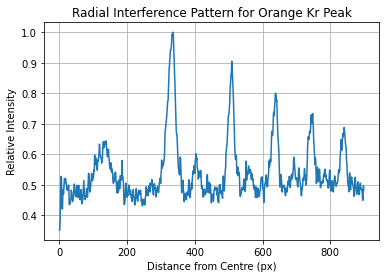

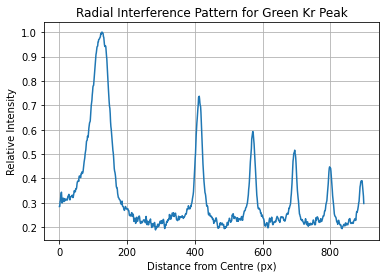

In [657]:
plt.figure()
plt.title('Radial Interference Pattern for Orange Kr Peak')
plt.xlabel('Distance from Centre (px)')
plt.ylabel('Relative Intensity')
plt.plot(interp1)
plt.grid()
plt.show()

plt.figure()
plt.title('Radial Interference Pattern for Green Kr Peak')
plt.xlabel('Distance from Centre (px)')
plt.ylabel('Relative Intensity')
plt.plot(interp2)
plt.grid()
plt.show()

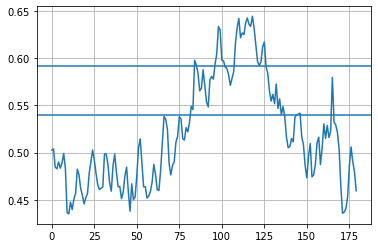

In [658]:
mean = np.mean(interp1)
y0 = interp1[20:200]

plt.figure()
plt.plot(y0)
plt.axhline(y=mean)
plt.axhline(y=(mean+max(y0))/2)
plt.grid()
plt.show()
# Maxima were found manually, since the data was fuzzier.
from uncertainties import ufloat
max10 = ufloat(115+20, (126-84)/2)
max11 = ufloat(290+46, 23/2)
max12 = ufloat(450+59, (65-49)/2)
max13 = ufloat(38+600, (45-30)/2)
max14 = ufloat(48+700, (52-34)/2)
max15 = ufloat(41+800, (47-34)/2)

max21 = ufloat(125, (150-92)/2)
max22 = ufloat(63+350, (72-53)/2)
max23 = ufloat(72+500, (78-64)/2)
max24 = ufloat(45+650, (50-38)/2)
max25 = ufloat(49+750, (54-44)/2)

149149+/-5 -38627+/-19
155810+/-6 -140487+/-24


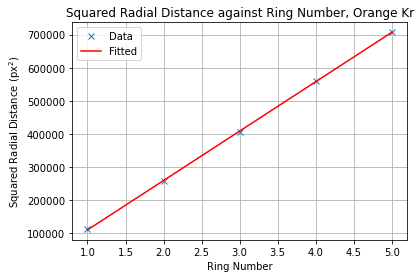

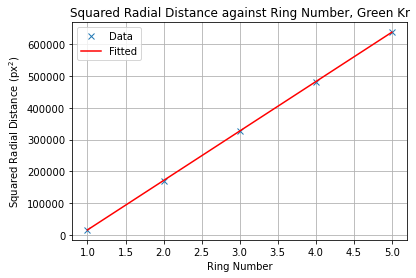

In [659]:
import uncertainties.umath as u

def nom(array): # Defining a .nominal_value function for arrays.
    output = np.zeros(len(array))
    for i in range(len(array)):
        output[i] = array[i].nominal_value
    return output

def std_dev(array):# Defining a .std_dev function for arrays.
    output = np.zeros(len(array))
    for i in range(len(array)):
        output[i] = array[i].std_dev
    return output

# Arrays of maxima.
maxarray1 = np.array([max11, max12, max13, max14, max15])
maxarray2 = np.array([max21, max22, max23, max24, max25])

# Arrays of maxima numbers.
numbers1 = np.arange(5) + 1
numbers2 = np.arange(5) + 1

x = nom(maxarray1)**2
sigma = 2*std_dev(maxarray1)

# Fitting of line to squared radial distance graph.
p1, cov1 = np.polyfit(numbers1, x, 1, w=1/sigma, cov='unscaled')
p2, cov2 = np.polyfit(numbers2, nom(maxarray2)**2, 1, w=0.5/std_dev(maxarray2), cov='unscaled')
slope1 = ufloat(p1[0], np.sqrt(cov1[0,0]))
slope2 = ufloat(p2[0], np.sqrt(cov2[0,0]))
int1 = ufloat(p1[1], np.sqrt(cov1[1,1]))
int2 = ufloat(p2[1], np.sqrt(cov2[1,1]))
print(slope1, int1)
print(slope2, int2)

plt.figure()
plt.title('Squared Radial Distance against Ring Number, Orange Kr')
plt.xlabel('Ring Number')
plt.ylabel('Squared Radial Distance (px$^2$)')
plt.plot(numbers1, nom(maxarray1)**2, 'x', label='Data')
plt.plot(numbers1, p1[0]*numbers1 + p1[1], color='red', label='Fitted')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title('Squared Radial Distance against Ring Number, Green Kr')
plt.xlabel('Ring Number')
plt.ylabel('Squared Radial Distance (px$^2$)')
plt.plot(numbers2, nom(maxarray2)**2, 'x', label='Data')
plt.plot(numbers2, p2[0]*numbers2 + p2[1], color='red',label='Fitted')
plt.legend()
plt.grid()
plt.show()

In [660]:
# Slope and intercept for Mercury peak.
peaks = maxima(arrays[0], 0.2)[0]
numbers0 = np.arange(len(peaks)) + 1
p0, cov0 = np.polyfit(numbers0, peaks**2, 1, cov='unscaled')
slope0 = ufloat(p0[0], np.sqrt(cov0[0,0]))
int0 = ufloat(p0[1], np.sqrt(cov0[1,1]))

# Fractional orders.
nfrac0 = -int0/slope0
nfrac1 = -int1/slope1
print(nfrac0, nfrac1)

# Wavelengths.
lam0 = 546.0750e-9
lam1 = 587.0916e-9
# Initial guess for order number, based on manufacturer value.
Nguess0 = int(2*1.995e-3/lam0)
print(Nguess0)

# Array of guesses.
N0array = np.arange(-5, 6) + Nguess0 + nfrac0
# Corresponding values of t.
tarray = N0array*lam0/2
# Corresponding orders of the first Kr graph.
N1array = 2*tarray/lam1
print(N0array)
print(N1array-nfrac1)

# Helpful for writing table in LaTeX.
string0 = ''
string1 = ''
string2 = ''
string3 = ''
for i in range(len(N1array)):
    string0 += f'{tarray[i].nominal_value*1e3:.4f} & '
    string1 += f'{N0array[i].nominal_value:.3f} & '
    string2 += f'{N1array[i].nominal_value:.3f} & '
    string3 += f'{(N1array[i]-nfrac1).nominal_value:.3f} & '
print(string0)
print(string1)
print(string2)
print(string3)

0.629827+/-0.000007 0.25898+/-0.00013
7306
[7301.629826743516+/-6.557054763591799e-06
 7302.629826743516+/-6.557054763591799e-06
 7303.629826743516+/-6.557054763591799e-06
 7304.629826743516+/-6.557054763591799e-06
 7305.629826743516+/-6.557054763591799e-06
 7306.629826743516+/-6.557054763591799e-06
 7307.629826743516+/-6.557054763591799e-06
 7308.629826743516+/-6.557054763591799e-06
 7309.629826743516+/-6.557054763591799e-06
 7310.629826743516+/-6.557054763591799e-06
 7311.629826743516+/-6.557054763591799e-06]
[6791.249371986808+/-0.00012995320596143967
 6792.1795079315225+/-0.00012995320596143967
 6793.109643876237+/-0.00012995320596143967
 6794.039779820951+/-0.00012995320596143967
 6794.969915765665+/-0.00012995320596143967
 6795.90005171038+/-0.00012995320596143967
 6796.830187655095+/-0.00012995320596143967
 6797.760323599809+/-0.00012995320596143967
 6798.690459544524+/-0.00012995320596143967
 6799.620595489238+/-0.00012995320596143967
 6800.550731433953+/-0.00012995320596143967

In [661]:
t = tarray[4]
n0 = N1array[4]
print(f'Confidence: {6795 - n0 + nfrac1}')
nfrac2 = -int2/slope2
print(nfrac2)
2*t/(530.02e-9)

Confidence: 0.03008+/-0.00013
0.90165+/-0.00016


7526.926922831148+/-6.755676540561472e-06

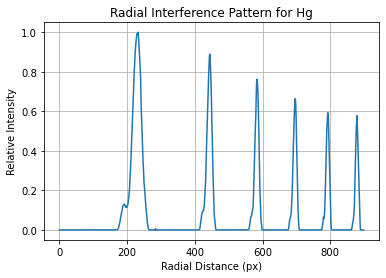

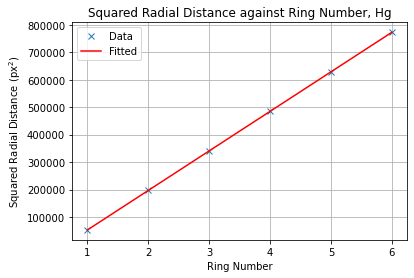

144007.2+/-1.7 -90582.6+/-0.9


In [662]:
# Plotting for Hg.

plt.figure()
plt.title('Radial Interference Pattern for Hg')
plt.xlabel('Radial Distance (px)')
plt.ylabel('Relative Intensity')
plt.plot(arrays[0])
plt.grid()
plt.show()

plt.figure()
plt.title('Squared Radial Distance against Ring Number, Hg')
plt.xlabel('Ring Number')
plt.ylabel('Squared Radial Distance (px$^2$)')
plt.plot(numbers0, peaks**2, 'x', label='Data')
plt.plot(numbers0, p0[0]*numbers0 + p0[1], color='red',label='Fitted')
plt.legend()
plt.grid()
plt.show()
print(s0, int0)

In [663]:
# Final calculation of the wavelength. Denominator was found via trial and error.
2*ufloat(1994714, 5)/ufloat(7495.90165, 0.00012)

532.2145602057092+/-0.0013340895340594365